In [18]:
# !pip install PyPDF2
# !pip install googletrans==4.0.0rc1

## Please find below the core functions of our program for performing the following actions

*   Convert cv2 to image
*   Convert Image to cv2
*   Cartoonise the image
*   Pass image list for generating row
*   Read image names from folder
*   Compress image
*   List all folder items except hidden files

## Importing the requisite libraries

In [19]:
import cv2
import numpy as np
import pandas as pd
from fpdf import FPDF
from PIL import Image as pili, ImageDraw as pild, ImageFont as pilf, ImageOps as piliops


## Defining the constant values

In [20]:
TINT_COLOR = (0, 0, 0)  # Black
OPACITY = int(255 * .50)
FONT = pilf.truetype("Inkfree.ttf", 24) # Font
IMG_BASE_WIDTH = 600
IMG_NUMBERS = 47

*   Convert cv2 to image
*   Convert Image to cv2

You have a RGB image represented by a 3d array, as in ex = numpy.array([ [ [1, 2, 3], [4, 5, 6] ], [ [7, 8, 9], [0, 1, 2] ] ]). So ex[0] is the first line of your image, ex[0][0] is the first column of the first line, ex[0][0][0] is the red component of the first pixel, ex[0][0][1] is the green component, and ex[0][0][2] is the blue component. In Order to work on the image you need to convert the format to ensure the other Libraries are able to make use of it.


In [21]:
def convert_from_cv2_to_image(img: np.ndarray) -> pili:
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def convert_from_image_to_cv2(img: pili) -> np.ndarray:
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

## Next we define one of our most important function - cartoonise 

cartoonizeblt_mem_nb 

A drawing is made by drawing the shapes in a picture, and then adding the colors, right? So we detect the shapes in the picture, and then superimpose the picture on top of the shapes. 

Initially we use `cv2.cvtColor()` to convert the image to greyscale

Then we use `cv2.medianBlur()` to blur the greyscale in order to remove details that are too fine (we need to trim the complexity of reality in order to create drawings!)

Now we use `cv2.adaptiveThreshold()` to detect the edges of the shapes in the image

Next we use `cv2.bitwise_and()` to **bitblt** (superimpose) the original image with its edges:

Next we decide on a font 

We draw a semi transperant rectange and add our subtitles on top of the same using `pild.Draw(overlay)` and `draw.text` functionality

In [ ]:
# Controls blur amount and line size and number of text lines. No bold font!
def cartoonizeblt_mem_nb(path_in, k, blur, line, text, nlines=1, font='verdana'):

    imgc = imgcompress_mem(path_in, k)

    line_size = line
    blur_value = blur
    gray = cv2.cvtColor(imgc, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.medianBlur(gray, blur_value)
    bigedges = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, line_size, blur_value)
    bigedges_pil = cv2.cvtColor(bigedges, cv2.COLOR_BGR2RGB) # Converting BGR to RGB

    toon = cv2.bitwise_and(imgc, imgc, mask=bigedges)
    if 0 == len(text):
        return toon
    
    myfont = (
        pilf.truetype("ITCKRIST.TTF", 6) if font=='ITCKRIST'
        else
            pilf.truetype("Inkfree.ttf", 
                24 if k == 16 else 18 if k == 14 else 18 if k == 12 else 20 if k == 8 else 82) if font=='Inkfree'
        else
            pilf.truetype(font + ".ttf", 8)
    )

    cblimg_pil = pili.fromarray(cv2.cvtColor(toon, cv2.COLOR_BGR2RGBA))

    overlay = pili.new('RGBA', cblimg_pil.size, TINT_COLOR+(0,))
    draw = pild.Draw(overlay)
    
    _, h = myfont.getsize(text)
    num_lines = nlines
    
    x, y = 0, cblimg_pil.height - (num_lines)*h-10
    draw.rectangle((x, y, x + cblimg_pil.width, y + (num_lines)*h+10), fill=TINT_COLOR+(OPACITY,))
    if k == 1:
        draw.text((x+10, y), text, fill=(255,255,255), font=myfont) #, stroke_width=1)
    elif k < 8:
        draw.text((x+10, y), text, fill=(255,255,255), font=myfont)
    else:
        draw.text((x+10, y), text, fill=(255,255,255), font=myfont) #, stroke_width=1)

    cblimg_pil = pili.alpha_composite(cblimg_pil, overlay)
    cblimg_pil = cblimg_pil.convert("RGB")

    return convert_from_image_to_cv2(cblimg_pil)

## Here we define our imgcompress_mem

This helps us to resize the image without ever saving it. Performing the same task in memory

In [ ]:
def imgcompress_mem(path_in, k):
    img = cv2.imread(path_in, cv2.IMREAD_UNCHANGED)
    # set the ratio of resized image
    width = int((img.shape[1])/k)
    height = int((img.shape[0])/k)

    # resize the image by resize() function of openCV library
    return cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

## Next, we have our simple row function

Now, this is the driver function. 
    
    Args:
        folder: Folder name where the images are stored
        list_im: List of image names
        list_opt: List of opt tag
        list_txt: List of subtitles for every image
        list_nlines: Array of lines for subtitles
        image_file_extension: the file extension of image (eg. png, jpeg, etc. )
        font: the font to be used on the image
        number_of_images_on_strip: the number of images which will make the strip ( eg. 3,4 )
        orientation: horizontal vs vertical


In [ ]:
def simple_row(folder, list_im, list_opt, list_txt, list_nlines, image_file_extension='', font='Dengl', number_of_images_on_strip=3, orientation='horizontal'):
    shape = len(list_im)
    
    # cartoonize them in memory with text
    cimgs = [ cartoonizeblt_mem_nb(folder + '/' + i + image_file_extension, 14, 5, 3, k, nlines=n, font=font)
              for i,j,k,n in zip(list_im, list_opt, list_txt, list_nlines) ]
    
    # resize
    heighto = int(cimgs[0].shape[0])
    widtho = int(cimgs[0].shape[1])
    
    # heighto / widtho = height / width ==> height = heighto / widtho * width
    width = 1000//number_of_images_on_strip
    height = int(heighto / widtho * width)
    cimgs_dim = (width, height)
    cimgsr = [ cv2.resize(cimgs[i], cimgs_dim, interpolation = cv2.INTER_AREA) for i in range(shape)]

    # add borders
    white = [255,255,255]
    if orientation=='horizontal':
        bcimgs = [ cv2.copyMakeBorder(i, 15, 15, 0, 0, cv2.BORDER_CONSTANT, value=white) for i in cimgsr ]
    else:
        bcimgs = [ cv2.copyMakeBorder(i, 15, 15, 15, 15, cv2.BORDER_CONSTANT, value=white) for i in cimgsr ]
        
    # stack them horizontally
    return np.concatenate([ bcimgs[i] for i in range(0,len(list_im)) ], axis=1)

## And last but not the least we have our utility functions

* listdir_nohidden - returns the files from a folder excluding the hidden files  
* get_image_names - reuturns the names of files with a particular tag ( eg. jpeg in this scenario ) 

In [ ]:
import os

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f
            
def get_image_names(folder_path):
    file_names = list(listdir_nohidden(folder_path))
    file_names = [ i for i in file_names if 'jpeg' in i ]
    file_names.sort()
    return file_names

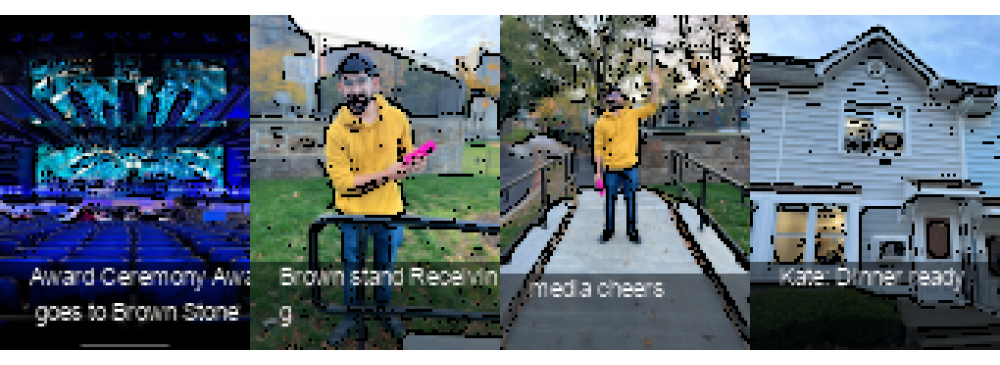

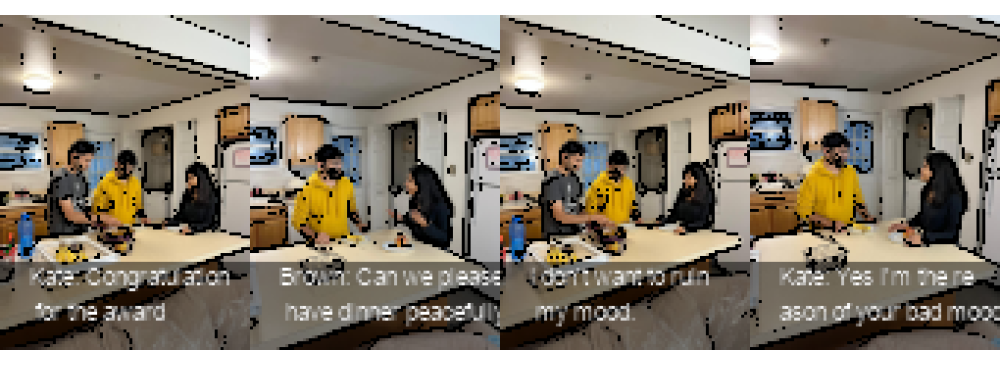

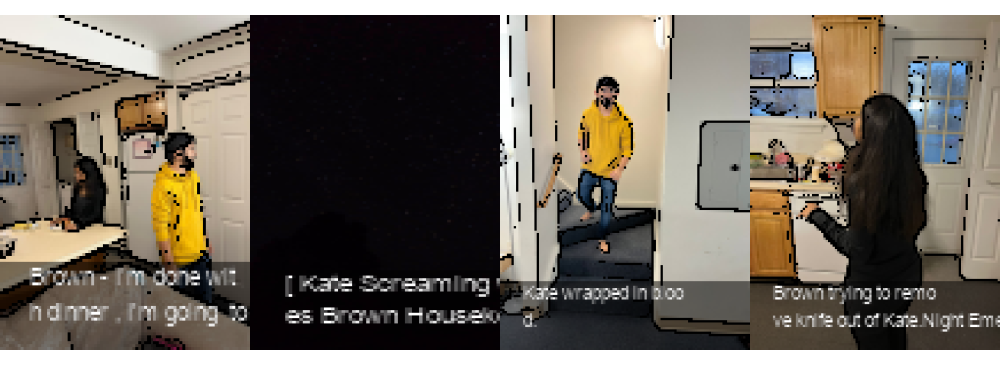

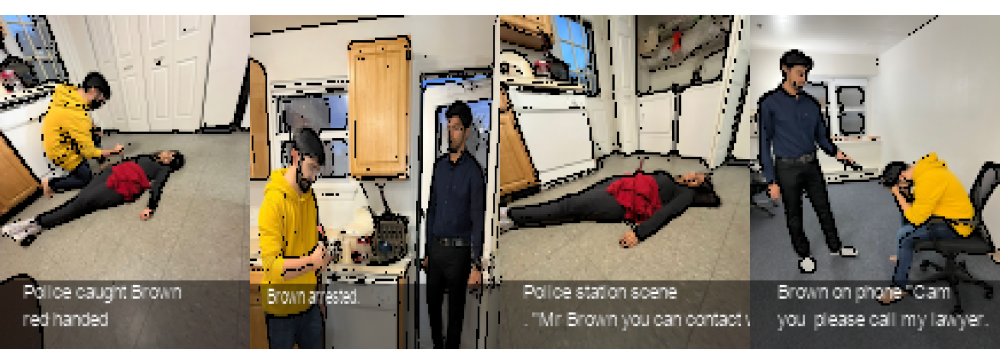

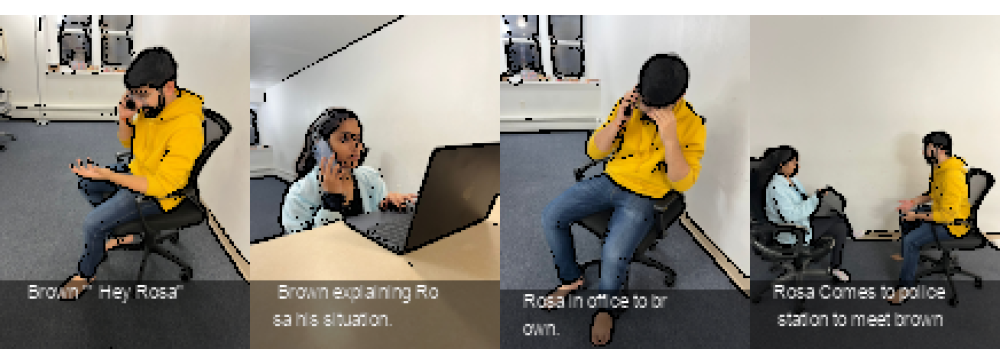

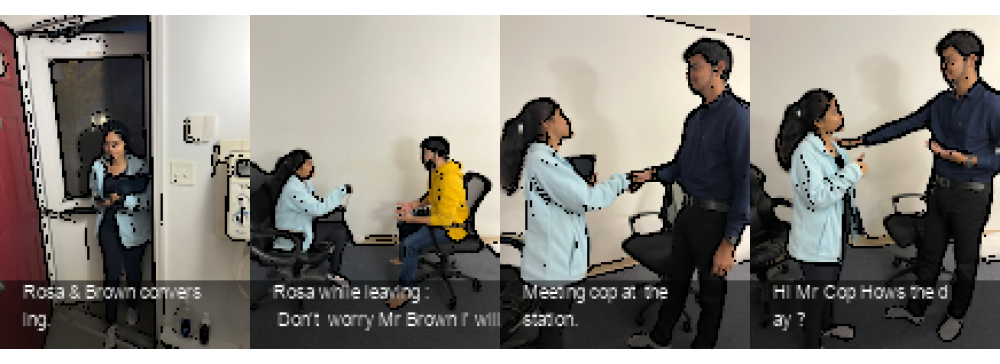

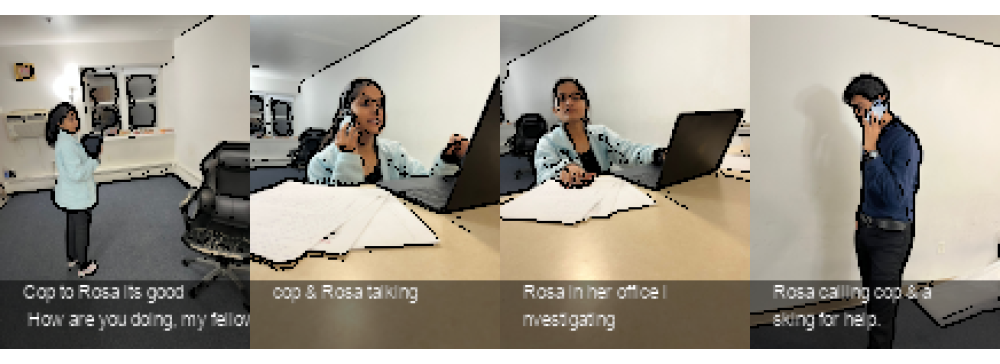

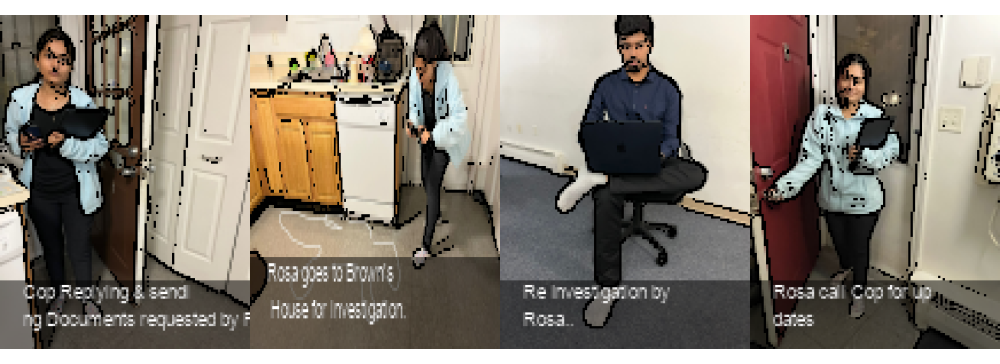

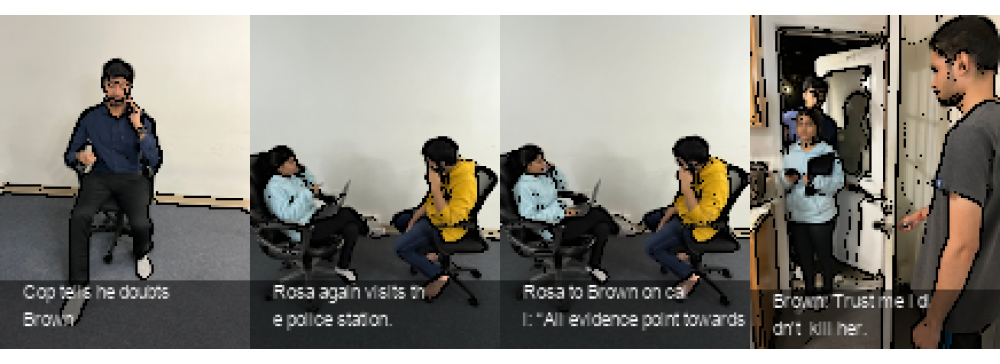

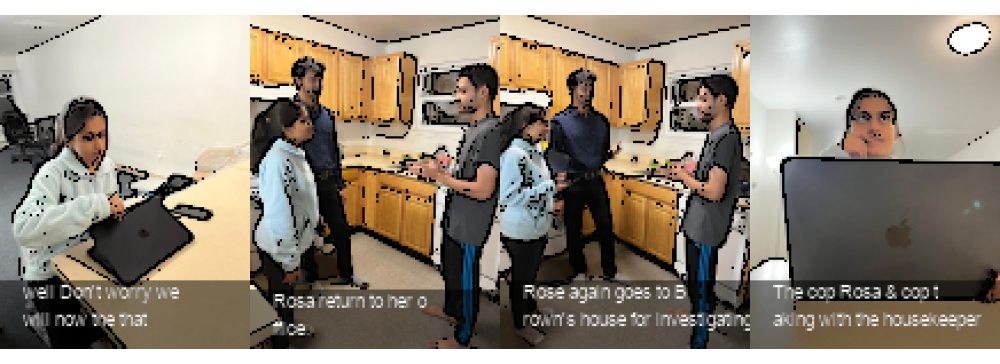

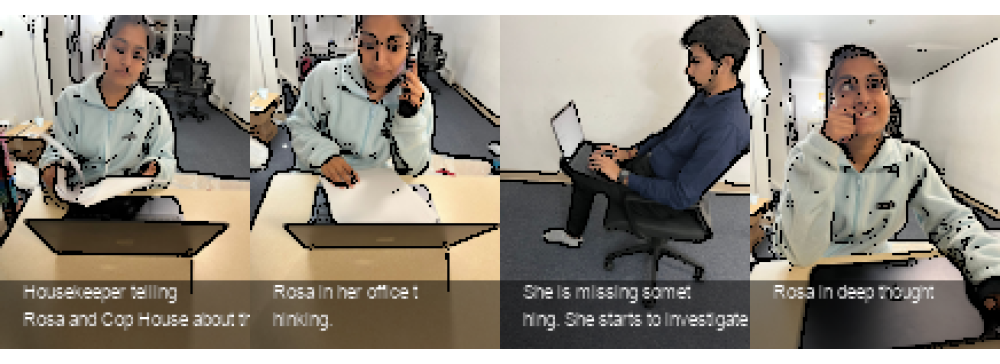

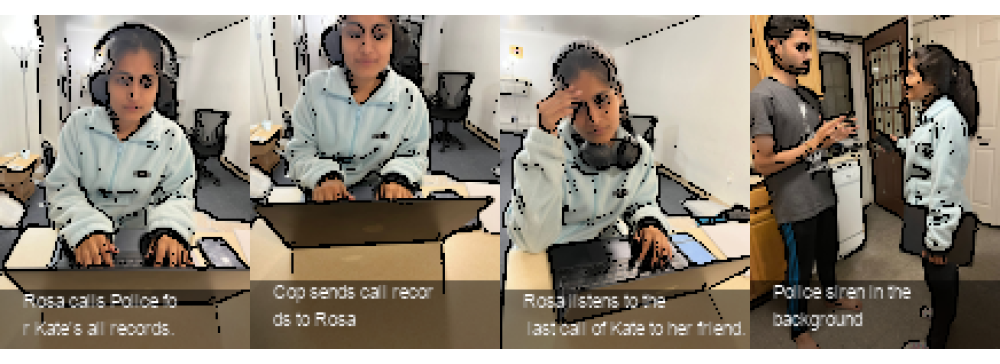

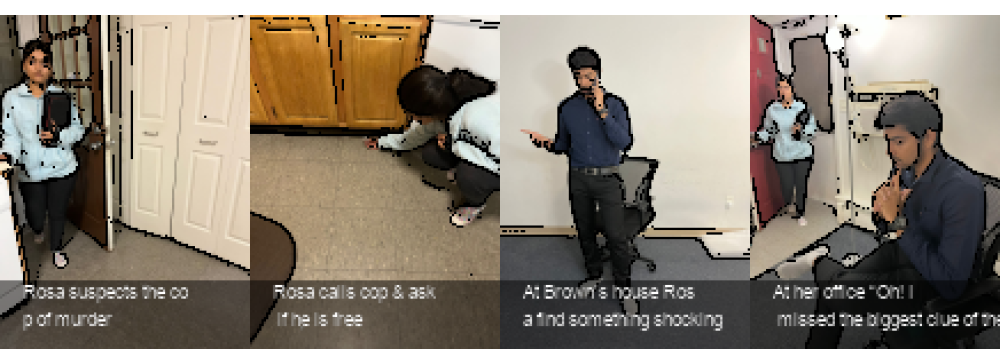

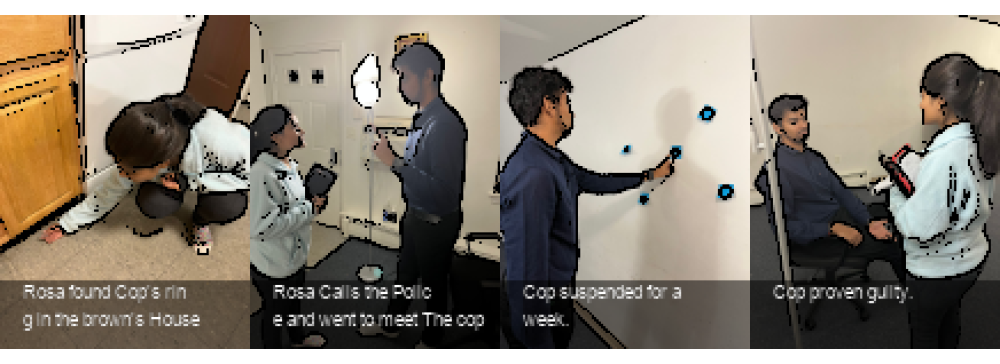

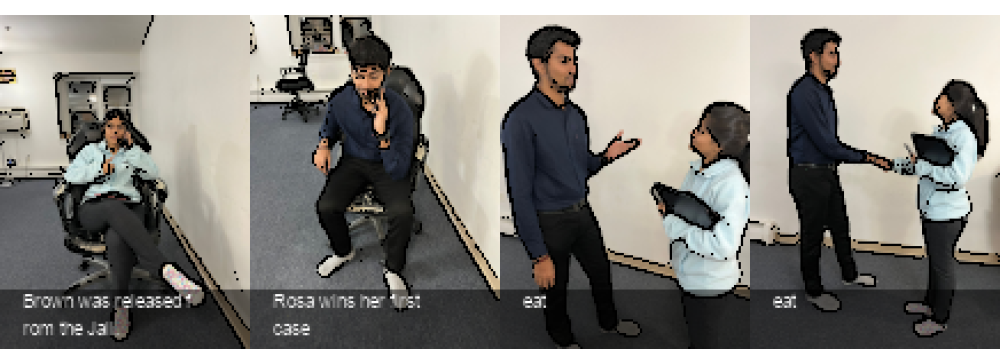

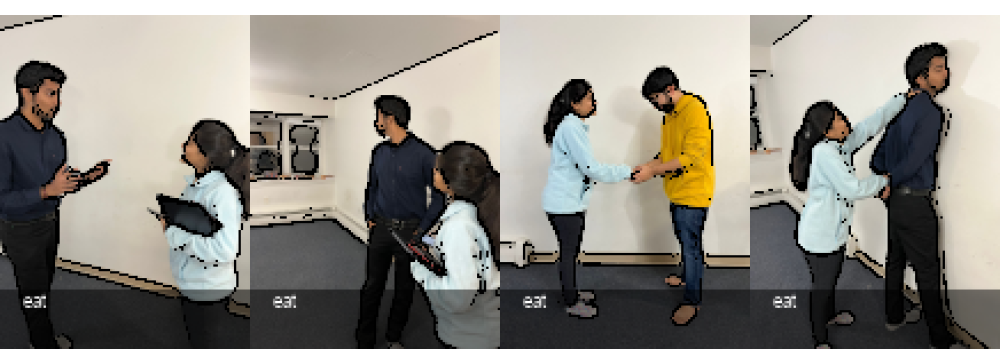

In [13]:
import os

folder_name = 'Images'
dir_list = get_image_names(folder_name)
dir_list

pencil = ['pencil' for i in range(len(dir_list))]
dialogues = [i[3:-1] for i in open('dialogues.txt', 'r').readlines()]
dialogues_with_line_break = [i[0:20]+'\n'+i[20:] for i in dialogues]

start = 0
end = 4
flag = True
final_row = None
final_pil = None
i=1
pdf_page_arr = []

while(flag):
    list_opt = pencil
    list_im = dir_list[start : end]
    list_txt = dialogues_with_line_break[start : end]
    list_nlines = [2]*len(dir_list)
    font = "Arial"

    rows4 = simple_row(
        folder = folder_name, 
        list_im = list_im,
        list_opt = list_opt,
        list_txt = list_txt,
        list_nlines = list_nlines,
        number_of_images_on_strip=end-start,
        font=font,
    )
    rows4_pil = cv2.cvtColor(rows4, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    final_pil = rows4_pil if final_pil is None else np.concatenate((final_pil, rows4_pil), axis=0)
    start = end
    end += min(np.random.choice([4], 1)[0], len(dir_list)-1)
    if end > 20*i:
        pili.fromarray(final_pil).save('english_page_{}.pdf'.format(i))
        i += 1
        final_pil = None

    if start >= len(dir_list):
        flag=False


Here we merge all the pdfs and delete the individual ones

In [5]:
!pip install PyPDF2

You should consider upgrading via the '/Users/deveshsurve/.pyenv/versions/3.9.4/bin/python3.9 -m pip install --upgrade pip' command.


In [6]:
from PyPDF2 import PdfFileMerger, PdfFileReader
merger = PdfFileMerger()

merger.append(PdfFileReader(open("english_page_1.pdf", 'rb')))
merger.append(PdfFileReader(open("english_page_2.pdf", 'rb')))
merger.append(PdfFileReader(open("english_page_3.pdf", 'rb')))

merger.write("enlish_comic.pdf") 

import os
os.remove('english_page_1.pdf')
os.remove('english_page_2.pdf')
os.remove('english_page_3.pdf')



ModuleNotFoundError: No module named 'PyPDF2'

Here we generate the Hindi Comic Book

In [5]:
import os

folder_name = 'sample_data'
dir_list = get_image_names(folder_name)
dir_list

pencil = ['pencil' for i in range(len(dir_list))]
from googletrans import Translator
translator = Translator()
dialogues = [ translator.translate(i[:-1], dest='hi', src='en').text for i in open('sample_data/dialogues.txt', 'r').readlines()]

start = 0
end = 4
flag = True
final_row = None
final_pil = None
i=1
pdf_page_arr = []

while(flag):
    list_opt = pencil
    list_im = dir_list[start : end]
    list_txt = dialogues[start : end]
    list_nlines = [1]*len(dir_list)
    font = "sample_data/nirmalas"

    rows4 = simple_row(
        folder = folder_name, 
        list_im = list_im,
        list_opt = list_opt,
        list_txt = list_txt,
        list_nlines = list_nlines,
        number_of_images_on_strip=end-start,
        font=font
    )
    rows4_pil = cv2.cvtColor(rows4, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    final_pil = rows4_pil if final_pil is None else np.concatenate((final_pil, rows4_pil), axis=0)
    start = end
    end += min(np.random.choice([4], 1)[0], len(dir_list)-1)
    if end > 20*i:
      pili.fromarray(final_pil).save('sample_data/hindi_page_{}.pdf'.format(i))
      i += 1
      final_pil = None

    if start >= len(dir_list):
        flag=False


In [6]:
from PyPDF2 import PdfFileMerger, PdfFileReader
merger = PdfFileMerger()

merger.append(PdfFileReader(open("sample_data/red_house.pdf", 'rb')))
merger.append(PdfFileReader(open("sample_data/hindi_page_1.pdf", 'rb')))
merger.append(PdfFileReader(open("sample_data/hindi_page_2.pdf", 'rb')))
merger.append(PdfFileReader(open("sample_data/hindi_page_3.pdf", 'rb')))
merger.append(PdfFileReader(open("sample_data/hindi_page_4.pdf", 'rb')))
merger.append(PdfFileReader(open("sample_data/hindi_page_5.pdf", 'rb')))

merger.write("sample_data/hindi_comic.pdf") 

import os
os.remove('sample_data/hindi_page_1.pdf')
os.remove('sample_data/hindi_page_2.pdf')
os.remove('sample_data/hindi_page_3.pdf')
os.remove('sample_data/hindi_page_4.pdf')
os.remove('sample_data/hindi_page_5.pdf')



In [7]:
import os

folder_name = 'sample_data'
dir_list = get_image_names(folder_name)
dir_list

pencil = ['pencil' for i in range(len(dir_list))]

start = 0
end = 3
flag = True
final_row = None
hindi_font = "sample_data/nirmalas"

while(flag):
    list_opt = pencil
    list_im = dir_list[start : end]
    list_txt = dialogues_hindi[start : end]
    list_nlines = [1]*len(dir_list)

    rows4 = simple_row(
        folder = folder_name, 
        list_im = list_im,
        list_opt = list_opt,
        list_txt = list_txt,
        list_nlines = list_nlines,
        font=hindi_font,
    )
    rows4_pil = cv2.cvtColor(rows4, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    start = end
    end += min(np.random.choice([2,3,4,5,6], 1)[0], len(dir_list)-1)
    if start >= len(dir_list):
        flag=False



NameError: ignored